# Generative Adversial Network (GAN) model

## Шаардлагатай сангуудаа оруулах

In [1]:
import os
import glob

import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

import tensorflow as tf
from keras import layers, models, losses
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, Flatten, LeakyReLU, BatchNormalization, MaxPooling1D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

import time

## Өгөгдлөө унших

In [2]:
dataset = pd.read_csv("../input/data.csv")

### Өгөгдлөө харах

In [3]:
display(dataset.head().T, dataset.shape)

,0,1,2,3,4
320,-1.388896,16.722093,0.329687,-10.598846,10.015236
321,0.05821,-1.186429,-0.747993,-5.978379,12.575455
322,5.898464,-10.186022,-1.588051,1.822014,13.012607
323,5.849397,-3.832706,0.152671,12.90642,13.932454
324,2.37903,12.73007,5.357345,21.049637,13.677982
...,...,...,...,...,...
1648,1.384356,-4.633642,-5.380405,10.001486,35.561525
1649,16.59277,-6.431111,-6.852814,1.22302,37.348663
1650,8.760738,25.847542,-2.682321,1.914469,11.53166
Diagnostic,Streptavidin,Streptavidin,Streptavidin,S,S


(89, 1333)

## Өгөгдлийн урьдчилсан боловсруулалт

In [4]:
def data_preprocessing_bin(dataset):

    X = dataset.drop(['Diagnostic', 'COVID-19_Status'], axis=1)
    X.columns = X.columns.astype(int)
    X = X.values
    y = dataset['COVID-19_Status']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    return X_train, X_test, y_train_encoded, y_test_encoded

In [6]:
X_train, X_test, y_train, y_test = data_preprocessing_bin(dataset)

In [ ]:
scaler = StandardScaler()
scaled_spectrum_train = scaler.fit_transform(X_train)
scaled_spectrum_test = scaler.fit_transform(X_test)

plt.figure(figsize=(20, 4))
plt.plot(scaled_spectrum_train[0])
plt.show()

In [ ]:
mean = X_train.mean()
std = X_train.std()

original_spectrum_train = (scaled_spectrum_train[0] * std) + mean

plt.figure(figsize=(20, 6))
plt.plot(original_spectrum_train, linestyle='dashed')
plt.plot(X_train.iloc[0], linestyle='dashed')
plt.show()

## GAN загвар

In [ ]:
np.expand_dims(X_train, axis=2)

In [ ]:
noise_dim = (100,)
feature_dim = X_train.shape[1]

In [ ]:
def build_generator():
    noise_dim = (100,)

    model = Sequential()
    model.add(Dense(100, input_shape=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(feature_dim, activation='tanh'))

    model.summary()

    noise = Input(shape=noise_dim)
    spectral = model(noise)

    return Model(noise, spectral)

In [ ]:
def build_discriminator():
    model = Sequential()

    model.add(Dense(512, input_shape=(feature_dim,)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    model.add((Dense(1, activation='sigmoid')))

    model.summary()

    spectral = Input(shape=feature_dim)
    validity = model(spectral)

    return Model(spectral, validity)

In [ ]:
def train(num_epochs, batch_size=4, save_interval=500):
    half_batch = int(batch_size / 2)
    for epoch in range(num_epochs):
        idx = np.random.randint(0, X_train.values.shape[0], half_batch)
        spectrum = X_train.values[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        gen_spectrum = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(spectrum, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_spectrum, np.zeros((half_batch, 1)))

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))

        valid_y = np.array([1] * batch_size)

        g_loss = combined.train_on_batch(noise, valid_y)

        print(f"{epoch} [D loss: {d_loss[0]}, acc: {100 * d_loss[1]:.2f}%] [G loss: {g_loss[0]}]")

        if epoch % save_interval == 0:
            save_spectrum(epoch)

In [ ]:
def save_spectrum(epoch):
    r, c = 2, 2
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_spectrum = generator.predict(nosie)

    gen_spectrum = 0.5 * gen_spectrum + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].plot(gen_spectrum[cnt, :, 0])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig('../figures/GAN/syntethic_spectrum_%d.png' % epoch)
    plt.close()

In [ ]:
optimizer = Adam(0.0002, 0.5)

In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
z = Input(shape=(100, ))
spectrum = generator(z)

discriminator.trainable = False
valid = discriminator(spectrum)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
train(num_epochs=100, batch_size=8, save_interval=10)

In [ ]:
discriminator.trainable = False
valid = discriminator(spectrum)

### The Generator model (Үүсгэгч загвар)

In [7]:
noise_dim = 100            
feature_dim = X_train.shape[1]

In [8]:
def make_generator_model():

    model = Sequential()
    model.add(layers.Input((noise_dim)))
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    
    model.add(layers.Dense(256, activation="leaky_relu"))    
    model.add(layers.Dense(feature_dim))
    model.compile()
    
    print(model.output_shape)
    assert model.output_shape == (None, feature_dim)               

    return model

In [9]:
generator = make_generator_model()
generator.summary()

(None, 1331)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_2 (Bat  (None, 64)    

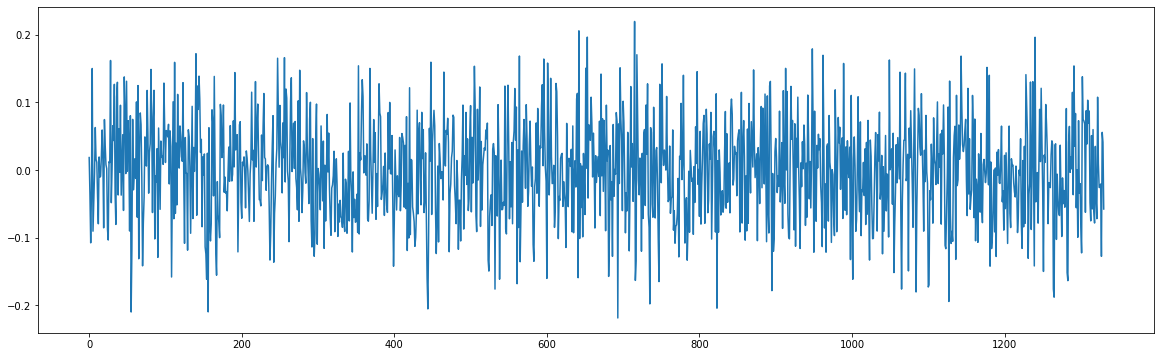

In [12]:
noise = tf.random.normal([1, noise_dim])
generated_data = generator(noise, training=False)
generated_data_ = generated_data.numpy().reshape(-1).tolist()
plt.figure(figsize=(20,6))
plt.plot(generated_data_)
# plt.savefig('../figures/LatentNoise_2024_Winter.png', dpi=600, bbox_inches='tight', transparent=True)

In [26]:
def make_discriminator_model():
    
    model = Sequential()
    
    model.add(layers.Input(shape=(feature_dim, 1)))
    model.add(layers.Conv1D(kernel_size= 15, filters= 256, activation='leaky_relu'))
    model.add(layers.MaxPool1D())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv1D(kernel_size= 15, filters= 128)) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
        
    model.add(layers.MaxPool1D())
    model.add(layers.Dropout(0.2))      

    model.add(layers.Flatten())
    model.add(layers.Dense(64))
    model.add(layers.Dense(1))
    model.compile()
    
    return model

In [27]:
discriminator = make_discriminator_model()
decision = discriminator(generated_data)
print (decision)
generator.summary()

tf.Tensor([[0.00588475]], shape=(1, 1), dtype=float32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 

### Loss function болон Optimizer

In [28]:
cross_entropy = losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
generator_optimizer = Adam(1e-5)
discriminator_optimizer = Adam(1e-5)

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



In [31]:
seed = tf.random.normal([1, noise_dim])         

def draw_training_evolution(model, epoch, noise_input= seed):
  """
    Function that takes in the generator model, epoch number, and 
    does a prediction and plots the generated singal then saves it.
  """
  # `training` is set to False.
  # Thus, all layers run in inference mode (batchnorm).
  predictions = model(noise_input, training=False)
  
  for i in range(predictions.shape[0]):
    fig = plt.figure()
    plt.plot(predictions[i].numpy().tolist())
    plt.savefig('../output/evolution/image_at_epoch_{:04d}_{:04d}.png'.format(epoch, i))
    plt.close()

def generate_data(model, num_synthetic_to_gen=1):
  """
    Function that takes in the generator model and 
    does a prediction and returns it as a numpy array.
  """
  noise_input = tf.random.normal([num_synthetic_to_gen, noise_dim])
  predictions = model(noise_input, training=False)
  predictions = predictions.numpy()
  return predictions

def calc_accuracy(prediction):
  """
    Function that takes in the some data judgements 
    from the discriminator and get the average of 
    judgements that indicate how the discriminator is fooled.
  """
  prediction_clipped = tf.clip_by_value(prediction, 0.0, 1.0, name=None)
  return tf.reduce_mean(prediction_clipped)

In [32]:
BATCH_SIZE = 4 

In [33]:
# `tf.function` # This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    """
      Function for implementing one training step 
      of the GAN model
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim], seed=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_data = generator(noise, training=True)

      real_output = discriminator(data, training=True)
      fake_output = discriminator(generated_data, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      acc = calc_accuracy(fake_output)
     
        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, acc

In [34]:
numofEPOCHS = 10000

In [35]:
def train(dataset, epochs):
  """
    Main GAN Training Function
  """
  epochs_gen_losses, epochs_disc_losses, epochs_accuracies = [], [], []

  for epoch in range(epochs):
    start = time.time()

    gen_losses, disc_losses, accuracies = [], [], []

    for data_batch in dataset:
      gen_loss, disc_loss, acc = train_step(data_batch)
      accuracies.append(acc)
      gen_losses.append(gen_loss)
      disc_losses.append(disc_loss)

    epoch_gen_loss  = np.average(gen_losses)
    epoch_disc_loss = np.average(disc_losses)
    epoch_accuracy = np.average(accuracies)
    epochs_gen_losses.append(epoch_gen_loss)
    epochs_disc_losses.append(epoch_disc_loss)
    epochs_accuracies.append(epoch_accuracy)
    print("Epoch: {}/{}".format(epoch+1, epochs))
    print("Generator Loss: {}, Discriminator Loss: {}".format(epoch_gen_loss, epoch_disc_loss))
    print("Accuracy: {}".format(epoch_accuracy))
      
    # Draw the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      draw_training_evolution(generator, epoch+1)
        
    # Save the model every 2 epochs for the last 2000 epochs
    if (epoch + 1) % 2 == 0 and epoch > (numofEPOCHS - 2000):
      checkpoint.save(file_prefix = checkpoint_prefix)   # Comment not to save model checkpoints while training
      

  return epochs_gen_losses, epochs_disc_losses, epochs_accuracies  

In [36]:
EPOCHS = numofEPOCHS

epochs_gen_losses, epochs_disc_losses, epochs_accuracies = train(X_train, EPOCHS)

ValueError: in user code:

    File "C:\Users\lemon\AppData\Local\Temp\ipykernel_20156\2606539796.py", line 13, in train_step  *
        real_output = discriminator(data, training=True)
    File "c:\Users\lemon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\lemon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).
    
    Input 0 of layer "conv1d_3" is incompatible with the layer: expected min_ndim=3, found ndim=1. Full shape received: (1331,)
    
    Call arguments received by layer 'sequential_3' (type Sequential):
      • inputs=tf.Tensor(shape=(1331,), dtype=float64)
      • training=True
      • mask=None
